# Boosting


__Scenario__: Hypothesis class $\mathcal H$, whose set of classifiers has large bias and the training error is high.

__Famous question__: In his machine learning class project in 1988 Michael Kearns famously asked the question: Can weak learners (H) be combined to generate a strong learner with low bias?

__Famous answer:__ Yes! (Robert Schapire in 1990)

__Solution:__ Create ensemble classifier $H_T(\vec x) = \sum_{t = 1}^{T}\alpha_t h_t(\vec{x})$. 

This ensemble classifier is built in an iterative fashion. 
1. In iteration t we add the classifier $\alpha_t h_t (\vec x)$ to the ensemble. 
2. At test time we evaluate all classifier and return the weighted sum.

The process of constructing such an ensemble in a stage-wise fashion is very similar to gradient descent. 

However, instead of updating the model parameters in each iteration, we add functions to our ensemble.

Let $\ell$ denote a (convex and differentiable) loss function. With a little abuse of notation we write


\begin{equation}
  \ell (H)=\frac{1}{n}\sum_{i=1}^n \ell (H(\mathbf{x}_i),y_i).
\end{equation}

Assume we have already finished t iterations and already have an ensemble classifier $H_t (\vec x)$. Now in iteration t+1 we want to add one more weak learner $h_{t+1}to the ensemble. To this end we search for the weak learner that minimizes the loss the most,

\begin{equation}
  h_{t+1} = \textrm{argmin}_{h \in \mathbb{H}}\ell(H_t + \alpha h_t).
\end{equation}
Once $h_{t+1}$ has been found, we add it to our ensemble, i.e,. $H_{t+1} := H_t + \alpha h_t $

# How can we find such $h \in \mathcal H$

Use gradient descent in function space. In function space, inner product can be defined as 


$$ < h,g >=\int\limits_x h(x)g(x)dx $$ 


Since we only have training set, we define it as
$$ <h,g> = \sum_i ^n h(x_i) g(x_i) $$


# Gradient descent in functional space

Given $\mathcal H$, we wan to find the step-size $\alpha$ and $h$ to minimize the loss $\ell(H + \alpha h).$ Use [Taylor Approximation](https://en.wikipedia.org/wiki/Taylor_series) on $\ell (\mathcal H + \alpha h)$.

$$ \ell (\mathcal H + \alpha h) \approx \ell(H) + \alpha <\Delta \ell(H), h>$$

This approximation (of $\ell$ as a linear function only holds within a small region around $\ell (H)$, i.e., as long as $\alpha$ is small.


### 1. $$ \begin{equation}
\textrm{argmin}_{h\in H}\ell(H+\alpha h) \approx \textrm{argmin}_{h\in H} \; \ell(H) + \big< \nabla \frac{\partial \ell}{\partial H},\alpha h \big>
\end{equation}$$

The first-order Taylor approximation says that
$$ \ell(a) \approx \ell(a) + (b-a) \frac{\partial \ell(a)}{\partial a}$$
+ If $\alpha$ is small, this appproximation holds. 

+ The second term denotes the inner product of two functions.



### 2. $$ \approx \textrm{argmin}_{h\in H} \big< \nabla \frac{\partial \ell}{\partial H},\alpha h \big>
$$

+ $\ell(H)$ dropts as it is not a function of $h$. We need to know
__what is the inner product between a function and derivative of a loss function w.r.t. another function__.




### 3 .$$ \begin{equation}
\textrm{argmin}_{h\in H}\ell(H+\alpha h) \approx \textrm{argmin}_{h \in \mathbb{H}}\sum_{i = 1}^{n}\frac{\partial \ell}{\partial [H(\mathbf{x}_i)]}h(\mathbf{x}_i) \end{equation}$$

We can write 
$$ \ell(H) = \sum_{i = 1}^{n}\ell(H(\mathbf{x}_i)) = \ell(H(x_1), \dots , H(x_n)) $$

(each prediction is an input to the loss function) $ \frac{\partial \ell}{\partial H}(\mathbf{x}_i) = \frac{\partial \ell}{\partial [H(\mathbf{x}_i)]} $

So we can do boosting if we have an algorithm $\mathcal A$ to solve

$$ h_{t+1} = \textrm{argmin}_{h \in \mathbb{H}} \sum_{i = 1}^{n} \underbrace{\frac{\partial \ell}{\partial [H(\mathbf{x}_i)]}}_{r_i} h(x) $$

We need a function $\mathbb{A}(\{(\mathbf{x}_1,r_1),\dots,(\mathbf{x}_n,r_n)\})=\textrm{argmin}_{h \in \mathbb{H}} \sum_{i = 1}^{n} r_i h(\mathbf{x}_i)$

# Gradient Boosting Regression Tree

In [1]:
%matplotlib inline
import numpy as np
from sklearn.datasets import load_iris,load_diabetes
import matplotlib.pyplot as plt
import pandas as pd
from typing import Optional
import matplotlib as mpl
import copy

np.random.seed(1)

In [2]:
def avg_squared_difference(y):
    return np.mean((y - y.mean()) ** 2)

class DecisionRegressionNode:
    def __init__(self, *, id, max_depth, depth):
        self.id = id
        self.max_depth = max_depth
        self.depth = depth
        self.left, self.right = None, None
        self.best_feature, self.feature_val = None, None
        self.gini_gain = None
        self.class_probability = dict()
        self.yhat = None

    def __str__(self):
        m = f'{self.id}\tDepth:{self.depth}\tFeature:{self.best_feature}\t'
        if self.feature_val is not None:
            m += f'Val:{self.feature_val:.3f}\tGiniGain:{self.gini_gain:.3f}\tPred:{self.class_probability}'
        return m

    @staticmethod
    def best_split(X, y):
        if isinstance(X,pd.DataFrame) is False:
            X=pd.DataFrame(X)
        features = list(X.columns)
        df = X.copy()
        y = y.copy()
        df['y'] = y

        max_gain = 0
        best_feature = None
        best_feature_avg = None

        for feature in features:

            gini_base = avg_squared_difference(y)
            mean_of_feature = df[feature].mean()

            dfleft, dfright = df[df[feature] <= mean_of_feature], df[df[feature] > mean_of_feature]

            lleft, lright = len(dfleft), len(dfright)
            lenght = lleft + lright

            w_left, w_right = lleft / lenght, lright / lenght

            gini_left, gini_right = avg_squared_difference(dfleft['y']), avg_squared_difference(dfright['y'])
            # Calculating the weighted GINI impurity
            weighted_gini = w_left * gini_left + w_right * gini_right
            gini_gain = gini_base - weighted_gini
            # print(
            #    f'Feature:{feature}\t Mean Value:{mean_of_feature:.3f},\t Weighted Gini:{weighted_gini:.3f},\t Gini Gain:{gini_gain:.3f}')
            if gini_gain > max_gain:
                best_feature = feature
                best_feature_avg = mean_of_feature
                # Setting the best gain to the current one
                max_gain = gini_gain
        return best_feature, best_feature_avg, max_gain

    def fit(self, X, y):
        if isinstance(X, pd.DataFrame) is False:
            X = pd.DataFrame(X)
            y = pd.Series(y)
        features = list(X.columns)

        self.best_feature, self.feature_val, self.gini_gain = self.best_split(X, y)
        self.yhat = y.mean()

        df = X.copy()
        y = y.copy()
        df['y'] = y
        if self.depth > self.max_depth or (self.best_feature is None):
            return self

        dfleft, dfright = df[df[self.best_feature] <= self.feature_val], df[
            df[self.best_feature] > self.feature_val]

        left_classes = dfleft['y'].value_counts().index.to_list()
        left_probs = (dfleft['y'].value_counts() / len(dfleft)).to_list()
        self.class_probability['Left'] = dict(zip(left_classes, left_probs))

        right_classes = dfright['y'].value_counts().index.to_list()
        right_probs = (dfright['y'].value_counts() / len(dfright)).to_list()

        self.class_probability['Right'] = dict(zip(right_classes, right_probs))
        self.left = DecisionRegressionNode(id=self.id + '_left', max_depth=self.max_depth, depth=self.depth + 1).fit(
            dfleft[features], dfleft['y'])
        self.right = DecisionRegressionNode(id=self.id + '_right', max_depth=self.max_depth, depth=self.depth + 1).fit(
            dfright[features], dfright['y'])
        # IF we reach here, then stopping criteria is fulfilled
        return self

    def predict(self, x):
        if self.best_feature is None:
            return  self.yhat.mean()

        boolean_output = x[self.best_feature] <= self.feature_val

        if boolean_output and self.left is not None:
            # Turn Left
            return self.left.predict(x)
        elif (boolean_output == False) and self.right is not None:
            # turn Right
            return self.right.predict(x)
        else:
            return self.yhat.mean()

class DecisionTree:
    def __init__(self, max_depth=None):
        self.X, self.y = None, None
        self.features = None
        # Saving the hyper parameters
        self.max_depth = max_depth if max_depth else 200
        self.root = None

    def fit(self, X, y,type_of_node=DecisionRegressionNode):
        self.root = type_of_node(id='Root', max_depth=self.max_depth, depth=0).fit(X.copy(), y.copy())
        return self

    def __str__(self):
        return str(self.root)

    def predict(self, X):
        if isinstance(X, pd.DataFrame) is False:
            X = pd.DataFrame(X)

        preds = []
        for index, x in X.iterrows():
            preds.append(self.root.predict(x))
        return np.array(preds).flatten()


# Gradient Boosted Decision Tree Regression

In [3]:
def gradient_bossting_trees_with_fixed_alphas(X,Y,max_depth=1,alpha=.1,n=50):
    predf=0 
    inputs,outputs=copy.deepcopy(X),copy.deepcopy(Y)
    print_count=n//10
    for i in range(1,n+1):
        # Compute Loss based on original outputs and current predictions
        ei = Y - predf
        # Update outputs according to loss incurred by our previous prediction
        outputs = ei
        
        # Train mode
        reg = DecisionTree(max_depth=max_depth).fit(inputs, outputs,type_of_node=DecisionRegressionNode)

        # Update prediction 
        predf += alpha*reg.predict(inputs)
        
        if i%print_count==0 or i ==n:
            print(f'Epoch: {i}:\tAvg. Squared Loss:{np.mean((Y-predf)**2)}')
    return predf

In [4]:
## Define a true function 
def f(x):
    return np.sin(x)

def generate_input(n):
    return np.linspace(-2, 2, num=n)

N = 50    # number of training points.
s = 0.05    # noise variance.

X = generate_input(N)
Y = f(X)+s*np.random.randn(N)

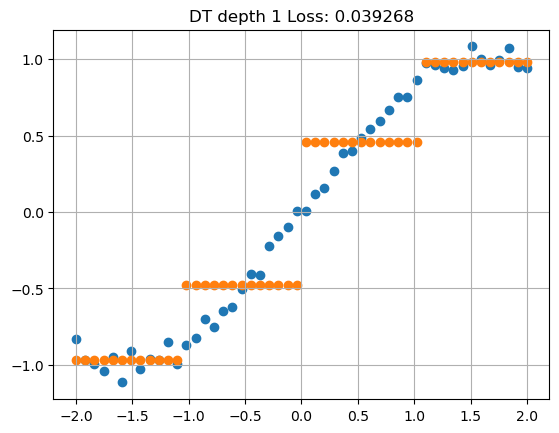

In [5]:
pred=DecisionTree(max_depth=1).fit(copy.deepcopy(X), copy.deepcopy(Y),type_of_node=DecisionRegressionNode).predict(copy.deepcopy(X))
plt.scatter(X,Y)
plt.scatter(X,pred)
plt.title(f'DT depth 1 Loss: {np.mean((Y-pred)**2):.6f}')
plt.grid()

Epoch: 100:	Avg. Squared Loss:0.11559822829282229
Epoch: 200:	Avg. Squared Loss:0.049495112214900355
Epoch: 300:	Avg. Squared Loss:0.040638638215682275
Epoch: 400:	Avg. Squared Loss:0.03945205070887902
Epoch: 500:	Avg. Squared Loss:0.039293072100526995
Epoch: 600:	Avg. Squared Loss:0.039271772198270626
Epoch: 700:	Avg. Squared Loss:0.039268918444291805
Epoch: 800:	Avg. Squared Loss:0.039268536099261606
Epoch: 900:	Avg. Squared Loss:0.03926848487279878
Epoch: 1000:	Avg. Squared Loss:0.039268478009493936


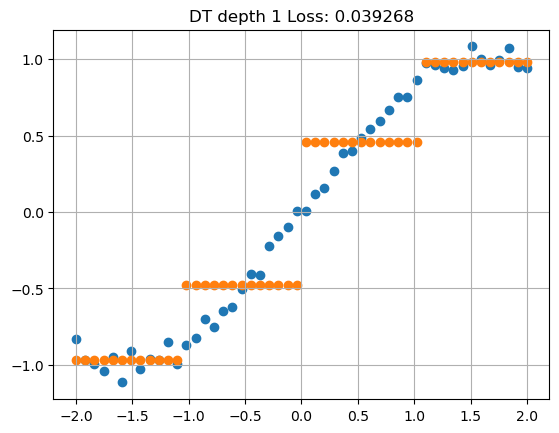

In [6]:
pred=gradient_bossting_trees_with_fixed_alphas(X,Y,alpha=.01,n=1000)
plt.scatter(X,Y)
plt.scatter(X,pred)
plt.title(f'DT depth 1 Loss: {np.mean((Y-pred)**2):.6f}')
plt.grid()

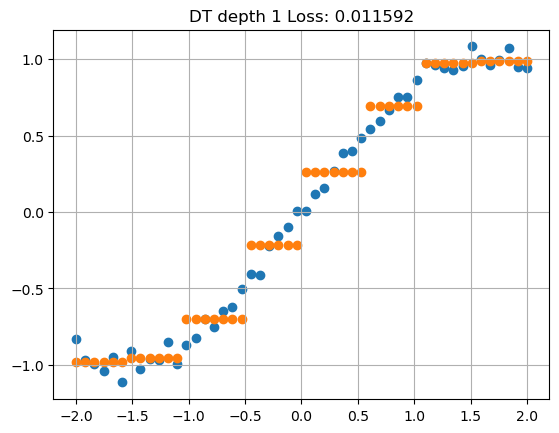

In [7]:
pred=DecisionTree(max_depth=2).fit(copy.deepcopy(X), copy.deepcopy(Y),type_of_node=DecisionRegressionNode).predict(copy.deepcopy(X))
plt.scatter(X,Y)
plt.scatter(X,pred)
plt.title(f'DT depth 1 Loss: {np.mean((Y-pred)**2):.6f}')
plt.grid()

Epoch: 10:	Avg. Squared Loss:0.08422045053463774
Epoch: 20:	Avg. Squared Loss:0.020421952093401318
Epoch: 30:	Avg. Squared Loss:0.012665544085014142
Epoch: 40:	Avg. Squared Loss:0.011722545947714925
Epoch: 50:	Avg. Squared Loss:0.011607899388896949
Epoch: 60:	Avg. Squared Loss:0.011593961043815541
Epoch: 70:	Avg. Squared Loss:0.01159226646645001
Epoch: 80:	Avg. Squared Loss:0.01159206044540297
Epoch: 90:	Avg. Squared Loss:0.011592035398053292
Epoch: 100:	Avg. Squared Loss:0.01159203235288031


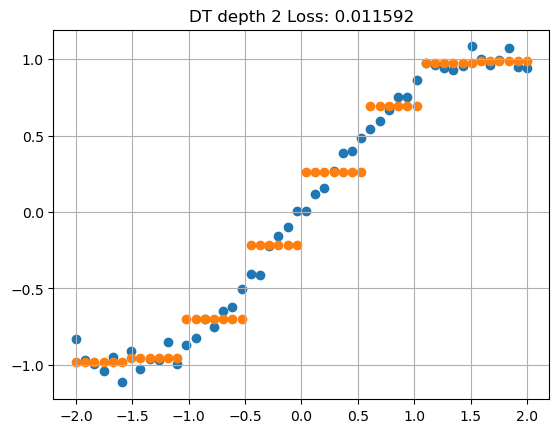

In [8]:
pred=gradient_bossting_trees_with_fixed_alphas(X,Y,max_depth=2,alpha=.1,n=100)
plt.scatter(X,Y)
plt.scatter(X,pred)
plt.title(f'DT depth 2 Loss: {np.mean((Y-pred)**2):.6f}')
plt.grid()

# The tast is very easy. Hence Not much of an improvement

In [9]:
X,y=load_diabetes(return_X_y=True)

In [10]:
pred=DecisionTree(max_depth=1).fit(copy.deepcopy(X), copy.deepcopy(y),type_of_node=DecisionRegressionNode).predict(copy.deepcopy(X))
print(f'DT depth 1 Loss: {np.mean((y-pred)**2):.6f}')

DT depth 1 Loss: 3622.711742


In [11]:
pred=DecisionTree(max_depth=3).fit(copy.deepcopy(X), copy.deepcopy(y),type_of_node=DecisionRegressionNode).predict(copy.deepcopy(X))
print(f'DT depth 3 Loss: {np.mean((y-pred)**2):.6f}')

DT depth 3 Loss: 2910.822660


In [12]:
pred=DecisionTree(max_depth=5).fit(copy.deepcopy(X), copy.deepcopy(y),type_of_node=DecisionRegressionNode).predict(copy.deepcopy(X))
print(f'DT depth 5 Loss: {np.mean((y-pred)**2):.6f}')

DT depth 5 Loss: 1958.249684


# Gradient Boosting 100 Decision Regression Trees

In [13]:
pred=gradient_bossting_trees_with_fixed_alphas(X,y,max_depth=1,alpha=.1,n=100)
print(f'DT depth 1 Loss: {np.mean((y-pred)**2):.6f}')

Epoch: 10:	Avg. Squared Loss:6528.515326754847
Epoch: 20:	Avg. Squared Loss:3550.7706206881967
Epoch: 30:	Avg. Squared Loss:3037.013201090766
Epoch: 40:	Avg. Squared Loss:2899.9725653829983
Epoch: 50:	Avg. Squared Loss:2814.4763218153034
Epoch: 60:	Avg. Squared Loss:2762.824730987714
Epoch: 70:	Avg. Squared Loss:2714.410076870103
Epoch: 80:	Avg. Squared Loss:2688.795392899784
Epoch: 90:	Avg. Squared Loss:2667.0049001020743
Epoch: 100:	Avg. Squared Loss:2650.1621649684607
DT depth 1 Loss: 2650.162165


In [14]:
pred=gradient_bossting_trees_with_fixed_alphas(X,y,max_depth=2,alpha=.1,n=100)
print(f'DT depth 2 Loss: {np.mean((y-pred)**2):.6f}')

Epoch: 10:	Avg. Squared Loss:6197.372825358515
Epoch: 20:	Avg. Squared Loss:3161.5394368802663
Epoch: 30:	Avg. Squared Loss:2641.2705432817843
Epoch: 40:	Avg. Squared Loss:2416.66771964921
Epoch: 50:	Avg. Squared Loss:2319.014488512071
Epoch: 60:	Avg. Squared Loss:2243.3377088434463
Epoch: 70:	Avg. Squared Loss:2148.6632183897964
Epoch: 80:	Avg. Squared Loss:2069.1684148661143
Epoch: 90:	Avg. Squared Loss:2002.0033899260352
Epoch: 100:	Avg. Squared Loss:1952.844146476107
DT depth 2 Loss: 1952.844146


# Adaptive Boosting

+ $y_i \in \{+1,-1\}$
+ $h \in \mathcal H$ are binary funcs,i.e,. $h(x) \in \{+1,-1\}$
+ Step-size: Line-search to obtain best $\alpha$
+ Loss func: $\ell (H) = \sum_i ^n exp(- y_i H(x_I)) $


### 1 .$$ \begin{equation}
\textrm{argmin}_{h\in H}\ell(H+\alpha h) \approx \textrm{argmin}_{h \in \mathbb{H}}\sum_{i = 1}^{n}\frac{\partial \ell}{\partial [H(\mathbf{x}_i)]}h(\mathbf{x}_i) \end{equation}$$

### 2. $$ r_i=\frac{\partial \ell}{\partial H(\mathbf{x}_i)}=-y_i {e^{-y_i H(\mathbf{x}_i)}} $$

In [15]:
data = load_diabetes()
data.keys()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])
del data
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


# Implementation of AdaBoost
1. https://geoffruddock.com/adaboost-from-scratch-in-python/
2. https://xavierbourretsicotte.github.io/AdaBoost.html

In [16]:
def plot_adaboost(X: np.ndarray,
                  y: np.ndarray,
                  clf=None,
                  sample_weights: Optional[np.ndarray] = None,
                  annotate: bool = False,
                  ax: Optional[mpl.axes.Axes] = None) -> None:
    """ Plot ± samples in 2D, optionally with decision boundary """

    assert set(y) == {-1, 1}, 'Expecting response labels to be ±1'

    if not ax:
        fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
        fig.set_facecolor('white')

    pad = 1
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad

    if sample_weights is not None:
        sizes = np.array(sample_weights) * X.shape[0] * 100
    else:
        sizes = np.ones(shape=X.shape[0]) * 100

    X_pos = X[y == 1]
    sizes_pos = sizes[y == 1]
    ax.scatter(*X_pos.T, s=sizes_pos, marker='+', color='red')

    X_neg = X[y == -1]
    sizes_neg = sizes[y == -1]
    ax.scatter(*X_neg.T, s=sizes_neg, marker='.', c='blue')

    if clf:
        plot_step = 0.01
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # If all predictions are positive class, adjust color map acordingly
        if list(np.unique(Z)) == [1]:
            fill_colors = ['r']
        else:
            fill_colors = ['b', 'r']

        ax.contourf(xx, yy, Z, colors=fill_colors, alpha=0.2)

    if annotate:
        for i, (x, y) in enumerate(X):
            offset = 0.05
            ax.annotate(f'$x_{i + 1}$', (x + offset, y - offset))

    ax.set_xlim(x_min+0.5, x_max-0.5)
    ax.set_ylim(y_min+0.5, y_max-0.5)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

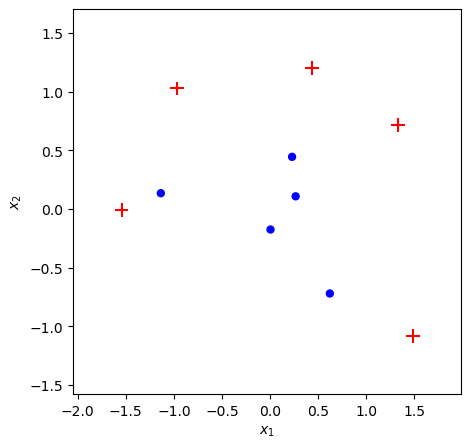

In [17]:
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split

def make_toy_dataset(n: int = 100, random_seed: int = None):
    """ Generate a toy dataset for evaluating AdaBoost classifiers """
    
    n_per_class = int(n/2)
    
    if random_seed:
        np.random.seed(random_seed)

    X, y = make_gaussian_quantiles(n_samples=n, n_features=2, n_classes=2)
    
    return X, y*2-1

X, y = make_toy_dataset(n=10, random_seed=10)
plot_adaboost(X, y)

Train error: 0.0%


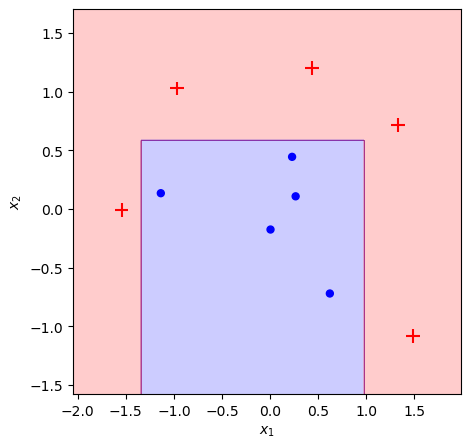

In [18]:
from sklearn.ensemble import AdaBoostClassifier

bench = AdaBoostClassifier(n_estimators=10, algorithm='SAMME').fit(X, y)
plot_adaboost(X, y, bench)

train_err = (bench.predict(X) != y).mean()
print(f'Train error: {train_err:.1%}')

In [19]:
class AdaBoost:
    """ AdaBoost enemble classifier from scratch """

    def __init__(self):
        self.stumps = None
        self.stump_weights = None
        self.errors = None
        self.sample_weights = None

    def _check_X_y(self, X, y):
        """ Validate assumptions about format of input data"""
        assert set(y) == {-1, 1}, 'Response variable must be ±1'
        return X, y

In [20]:
from sklearn.tree import DecisionTreeClassifier

def fit(self, X: np.ndarray, y: np.ndarray, iters: int):
    """ Fit the model using training data """

    X, y = self._check_X_y(X, y)
    n = X.shape[0]

    # init numpy arrays
    self.sample_weights = np.zeros(shape=(iters, n))
    self.stumps = np.zeros(shape=iters, dtype=object)
    self.stump_weights = np.zeros(shape=iters)
    self.errors = np.zeros(shape=iters)

    # initialize weights uniformly
    self.sample_weights[0] = np.ones(shape=n) / n

    for t in range(iters):
        # fit  weak learner
        curr_sample_weights = self.sample_weights[t]
        stump = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
        stump = stump.fit(X, y, sample_weight=curr_sample_weights)

        # calculate error and stump weight from weak learner prediction
        stump_pred = stump.predict(X)
        err = curr_sample_weights[(stump_pred != y)].sum()# / n
        stump_weight = np.log((1 - err) / err) / 2

        # update sample weights
        new_sample_weights = (
            curr_sample_weights * np.exp(-stump_weight * y * stump_pred)
        )
        
        new_sample_weights /= new_sample_weights.sum()

        # If not final iteration, update sample weights for t+1
        if t+1 < iters:
            self.sample_weights[t+1] = new_sample_weights

        # save results of iteration
        self.stumps[t] = stump
        self.stump_weights[t] = stump_weight
        self.errors[t] = err

    return self

In [21]:
def predict(self, X):
    """ Make predictions using already fitted model """
    stump_preds = np.array([stump.predict(X) for stump in self.stumps])
    return np.sign(np.dot(self.stump_weights, stump_preds))

Train error: 0.0%


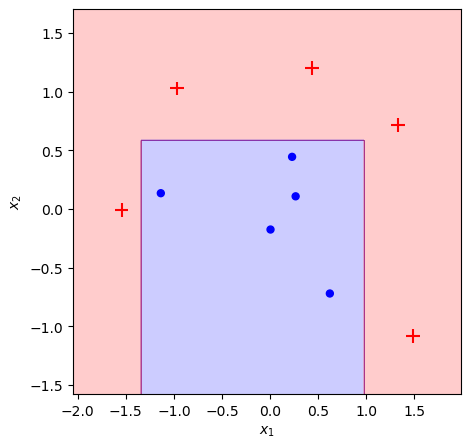

In [22]:
# assign our individually defined functions as methods of our classifier
AdaBoost.fit = fit
AdaBoost.predict = predict

clf = AdaBoost().fit(X, y, iters=10)
plot_adaboost(X, y, clf)

train_err = (clf.predict(X) != y).mean()
print(f'Train error: {train_err:.1%}')

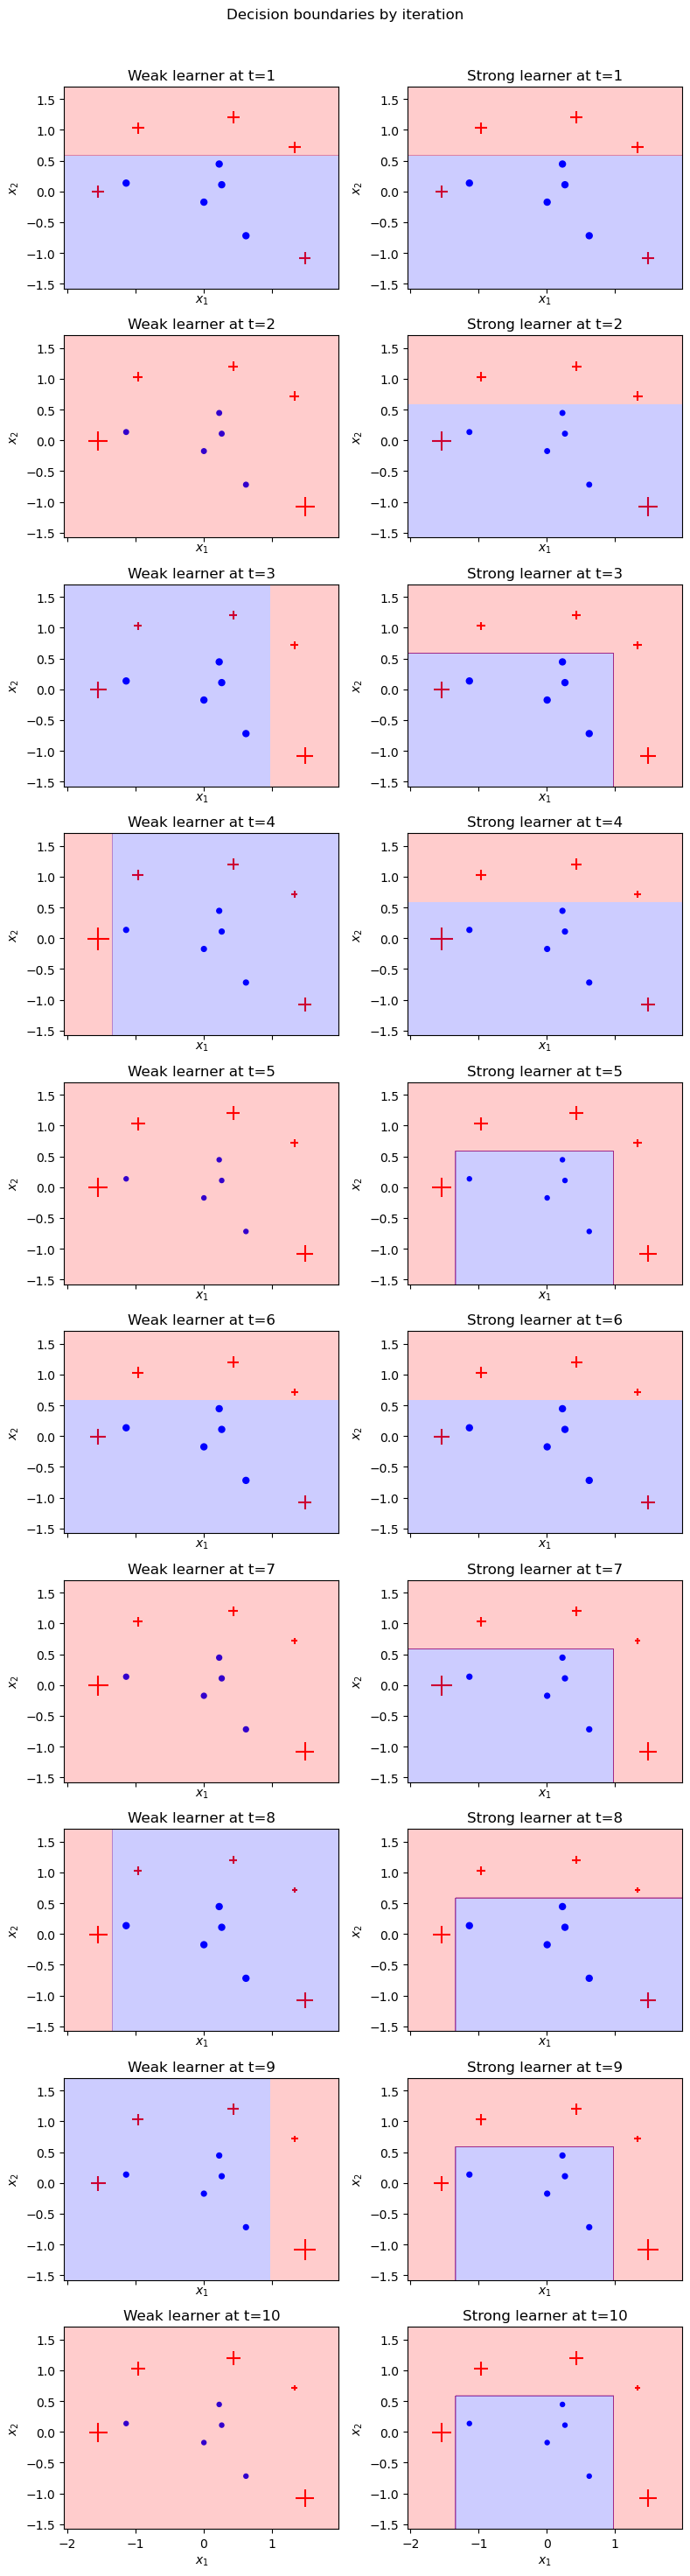

In [23]:
def truncate_adaboost(clf, t: int):
    """ Truncate a fitted AdaBoost up to (and including) a particular iteration """
    assert t > 0, 't must be a positive integer'
    from copy import deepcopy
    new_clf = deepcopy(clf)
    new_clf.stumps = clf.stumps[:t]
    new_clf.stump_weights = clf.stump_weights[:t]
    return new_clf


def plot_staged_adaboost(X, y, clf, iters=10):
    """ Plot weak learner and cumulaive strong learner at each iteration. """

    # larger grid
    fig, axes = plt.subplots(figsize=(8, iters*3),
                             nrows=iters,
                             ncols=2,
                             sharex=True,
                             dpi=100)
    
    fig.set_facecolor('white')

    _ = fig.suptitle('Decision boundaries by iteration')
    for i in range(iters):
        ax1, ax2 = axes[i]

        # Plot weak learner
        _ = ax1.set_title(f'Weak learner at t={i + 1}')
        plot_adaboost(X, y, clf.stumps[i],
                      sample_weights=clf.sample_weights[i],
                      annotate=False, ax=ax1)

        # Plot strong learner
        trunc_clf = truncate_adaboost(clf, t=i + 1)
        _ = ax2.set_title(f'Strong learner at t={i + 1}')
        plot_adaboost(X, y, trunc_clf,
                      sample_weights=clf.sample_weights[i],
                      annotate=False, ax=ax2)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

clf = AdaBoost().fit(X, y, iters=10)
plot_staged_adaboost(X, y, clf)